In [1]:
import numpy as np
import pandas as pd
from helper.Loader import Loader
import matplotlib.pyplot as plt
import seaborn as sns
from helper.get_data import pivot_table_all

In [2]:
database = 'market_research'
table_name = 'ohlc'
start_date = "2012-01-01"
end_date = "2022-01-26"

"""
"""
wind_codes = pd.read_csv('basic_material.txt',sep=' ', header=None,)
wind_codes = wind_codes[0].to_list()
field = "symbol,date,close"
# options = "PriceAdj=DP"
loader = Loader(start_date, end_date, database, table_name, field, None)
df = loader.fetch_data(database, table_name, wind_codes, field)
df.head()
table = pivot_table_all(df, 'date', 'symbol', 'close')
# print(table)


Data found!


In [3]:
df0 = table['000629.SZ']
df0.dropna(inplace=True)  # drop missing values in the feature set
df0 = df0.to_frame(name='000629.SZ')
df0 = df0.to_period(freq ='D')
df0.head()

,000629.SZ
date,
1996-11-15,14.35
1996-11-18,13.47
1996-11-19,13.95
1996-11-20,14.20
1996-11-21,14.25


In [4]:
df0 = df0["2021-05":]
df0['pct'] = df0['000629.SZ'].pct_change()
df0['cumprod'] = (df0['pct'] + 1).cumprod()
df0['Time'] = np.arange(len(df0.index))
# df0 = df0["2021-05":]
df0

,000629.SZ,pct,cumprod,Time
date,,,,
2021-05-06,18.3819,NaN,NaN,0
2021-05-07,19.4724,0.059325,1.059325,1
2021-05-10,21.0302,0.080000,1.144071,2
2021-05-11,20.5628,-0.022225,1.118644,3
2021-05-12,20.6407,0.003788,1.122882,4
...,...,...,...,...
2022-02-07,29.3644,0.027248,1.597463,183
2022-02-08,29.8317,0.015914,1.622884,184
2022-02-09,29.9096,0.002611,1.627122,185


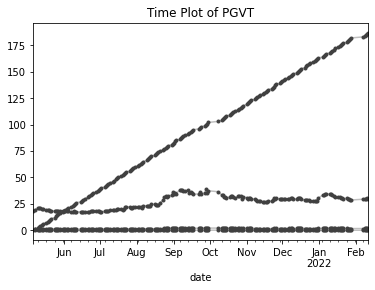

In [5]:
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
ax = df0.plot(**plot_params)
ax.set_title('Time Plot of PGVT');

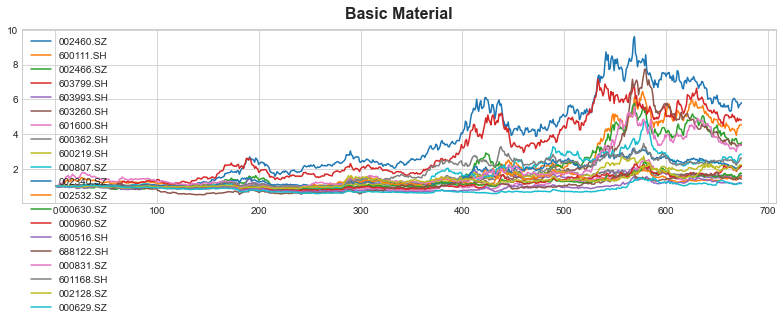

In [6]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
fig, ax = plt.subplots()
for wind_code in wind_codes:
    df0 = table[wind_code]
    # df0.dropna(inplace=True)
    df0 = df0.to_frame(name=wind_code)
    df0 = df0.to_period(freq ='D')
    df0 = df0["2019-05":]
    df0['Time'] = np.arange(len(df0.index))
    df0['pct'] = df0[wind_code].pct_change()
    df0['cumprod'] = (df0['pct'] + 1).cumprod()
    # ax = df0.plot(**plot_params)
    ax.plot('Time', 'cumprod', data=df0, label=wind_code)
    # ax = sns.regplot(x='Time', y=wind_code, data=df0, ci=None, scatter_kws=dict(color='0.25'))
    ax.set_title('Basic Material');
    _ = ax.legend()

In [7]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None, title='Periodograms'):
    from scipy.signal import periodogram
    fs = pd.Timedelta("5Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "5Y (1)",
            "2.5Y (2)",
            "1.25Y (4)",
            " (6)",
            "(12)",
            "(26)",
            "(52)",
            "(104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    # ax.set_title("Periodogram")
    ax.set_title(f"{title}")
    return ax

In [8]:
df0 = table['002460.SZ']
df0.dropna(inplace=True)  # drop missing values in the feature set
df0 = df0.to_frame(name='002460.SZ')
df0 = df0.to_period(freq ='D')
df0.head()

,002460.SZ
date,
2010-08-10,59.20
2010-08-11,62.30
2010-08-12,57.40
2010-08-13,57.25
2010-08-16,58.03


In [9]:
X = df0.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)
# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
X

,002460.SZ,day,week,dayofyear,year
date,,,,,
2010-08-10,59.20,1,32,222,2010
2010-08-11,62.30,2,32,223,2010
2010-08-12,57.40,3,32,224,2010
2010-08-13,57.25,4,32,225,2010
2010-08-16,58.03,0,33,228,2010
...,...,...,...,...,...
2022-02-07,1283.89,0,6,38,2022
2022-02-08,1210.72,1,6,39,2022
2022-02-09,1246.58,2,6,40,2022


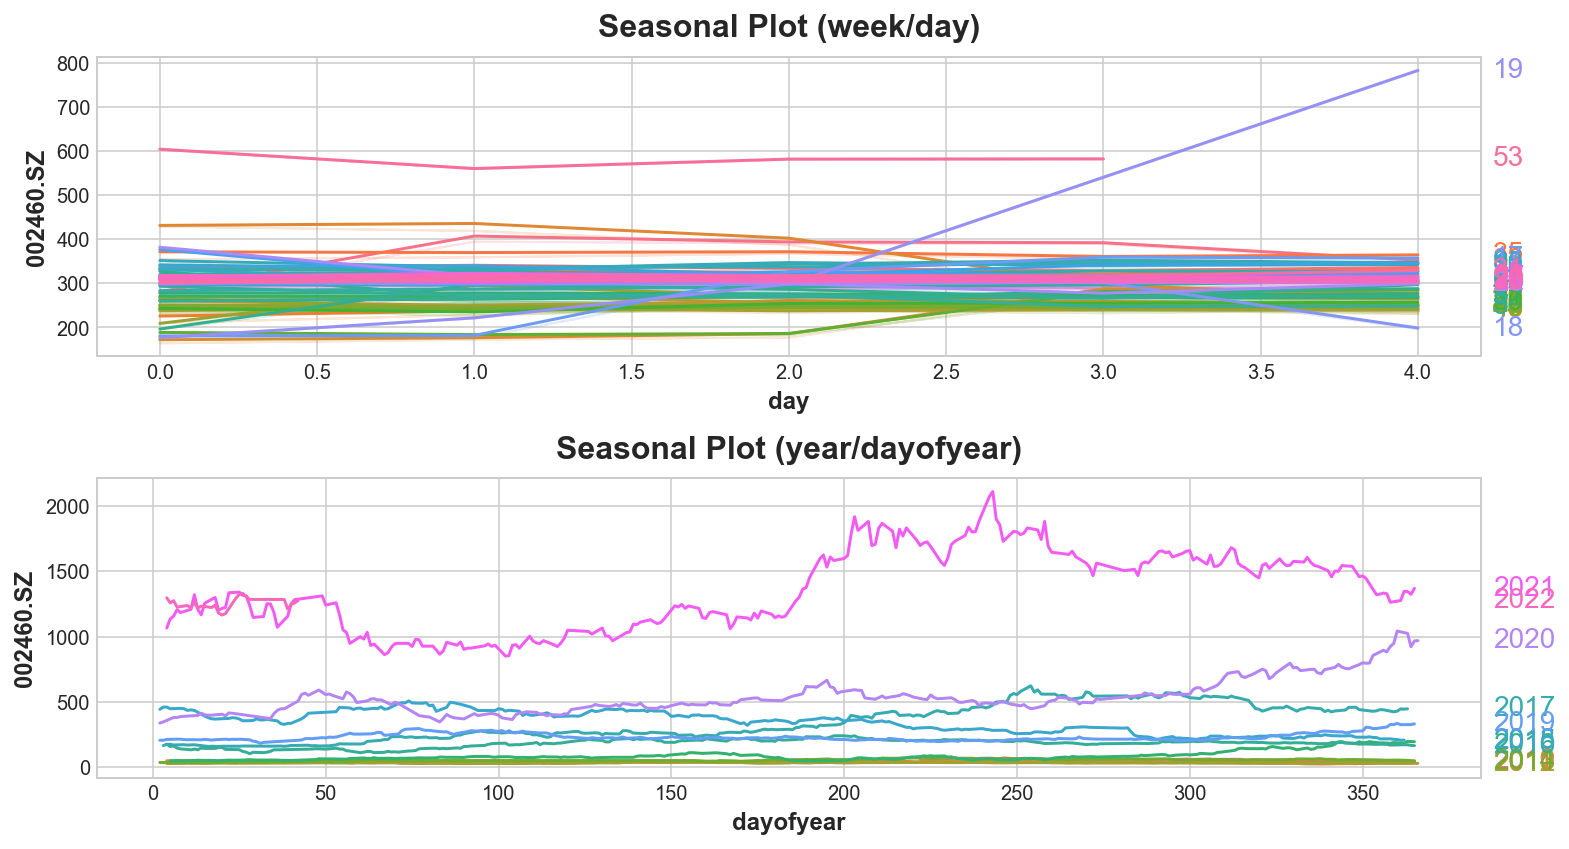

In [10]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="002460.SZ", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="002460.SZ", period="year", freq="dayofyear", ax=ax1);

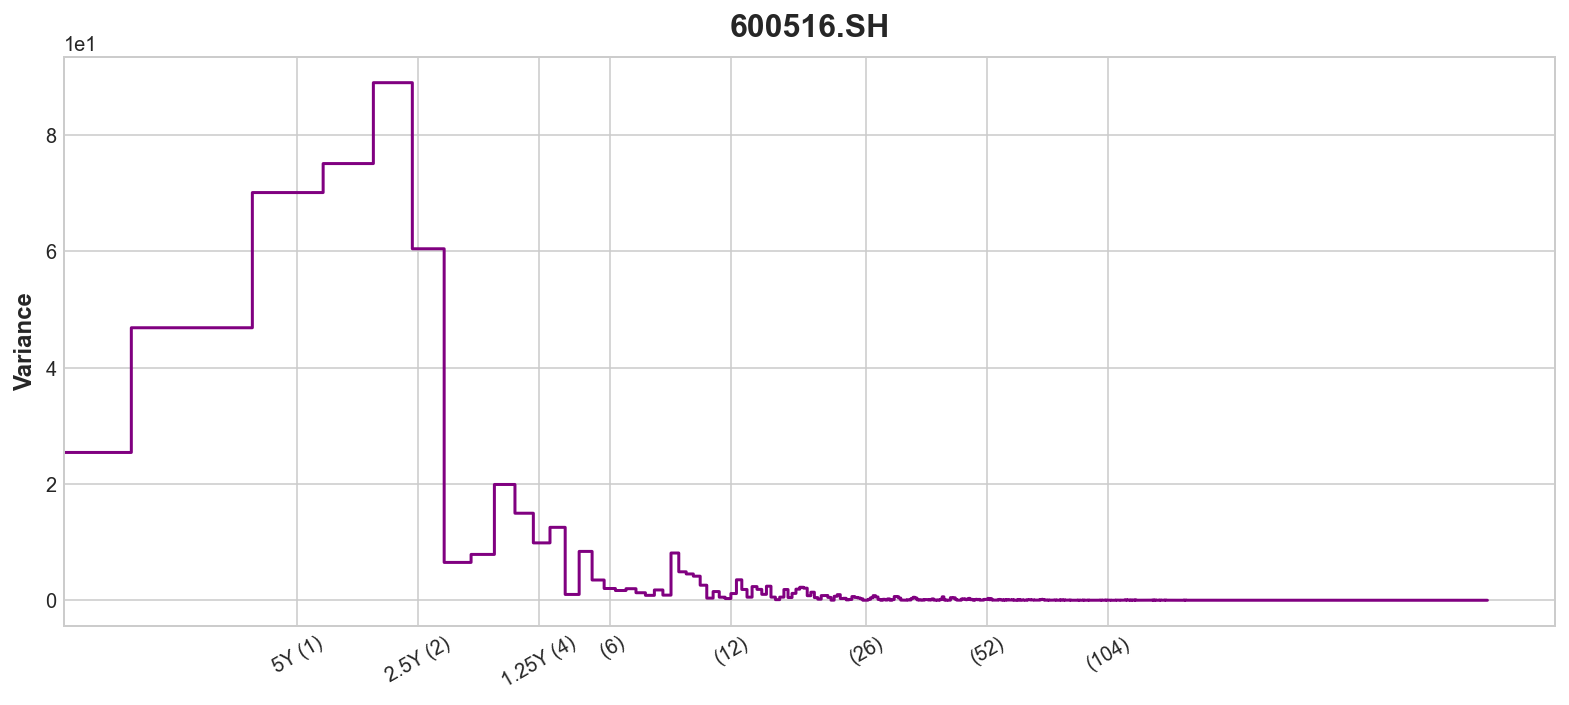

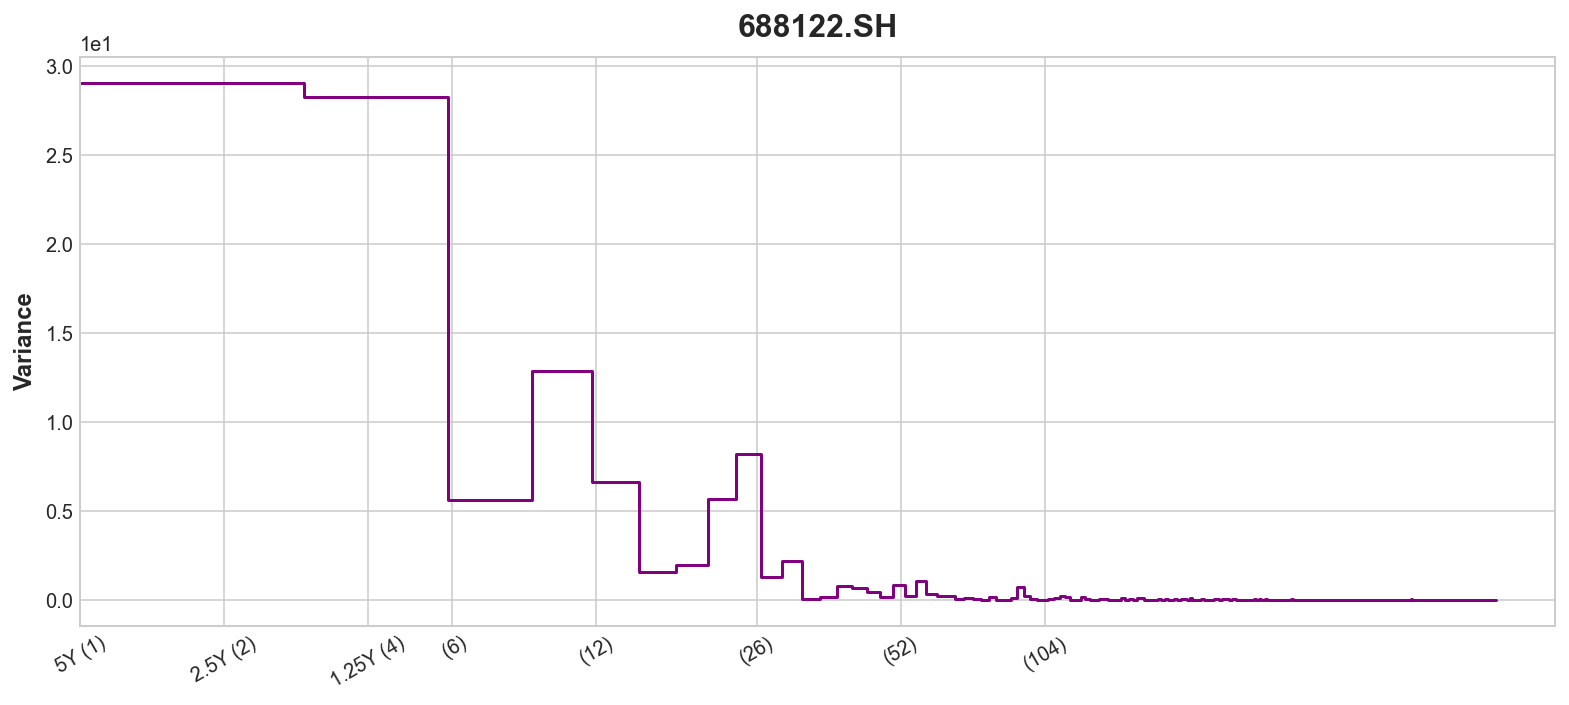

In [11]:
wind_codes = ["600516.SH", "688122.SH"]
for wind_code in wind_codes:
    df0 = table[wind_code]
    df0.dropna(inplace=True)
    df0 = df0.to_frame(name=wind_code)
    df0 = df0.to_period(freq ='D')
    # df0 = df0["2019-05":]
    plot_periodogram(df0[wind_code],title=wind_code);
# 600516.SH 688122.SH

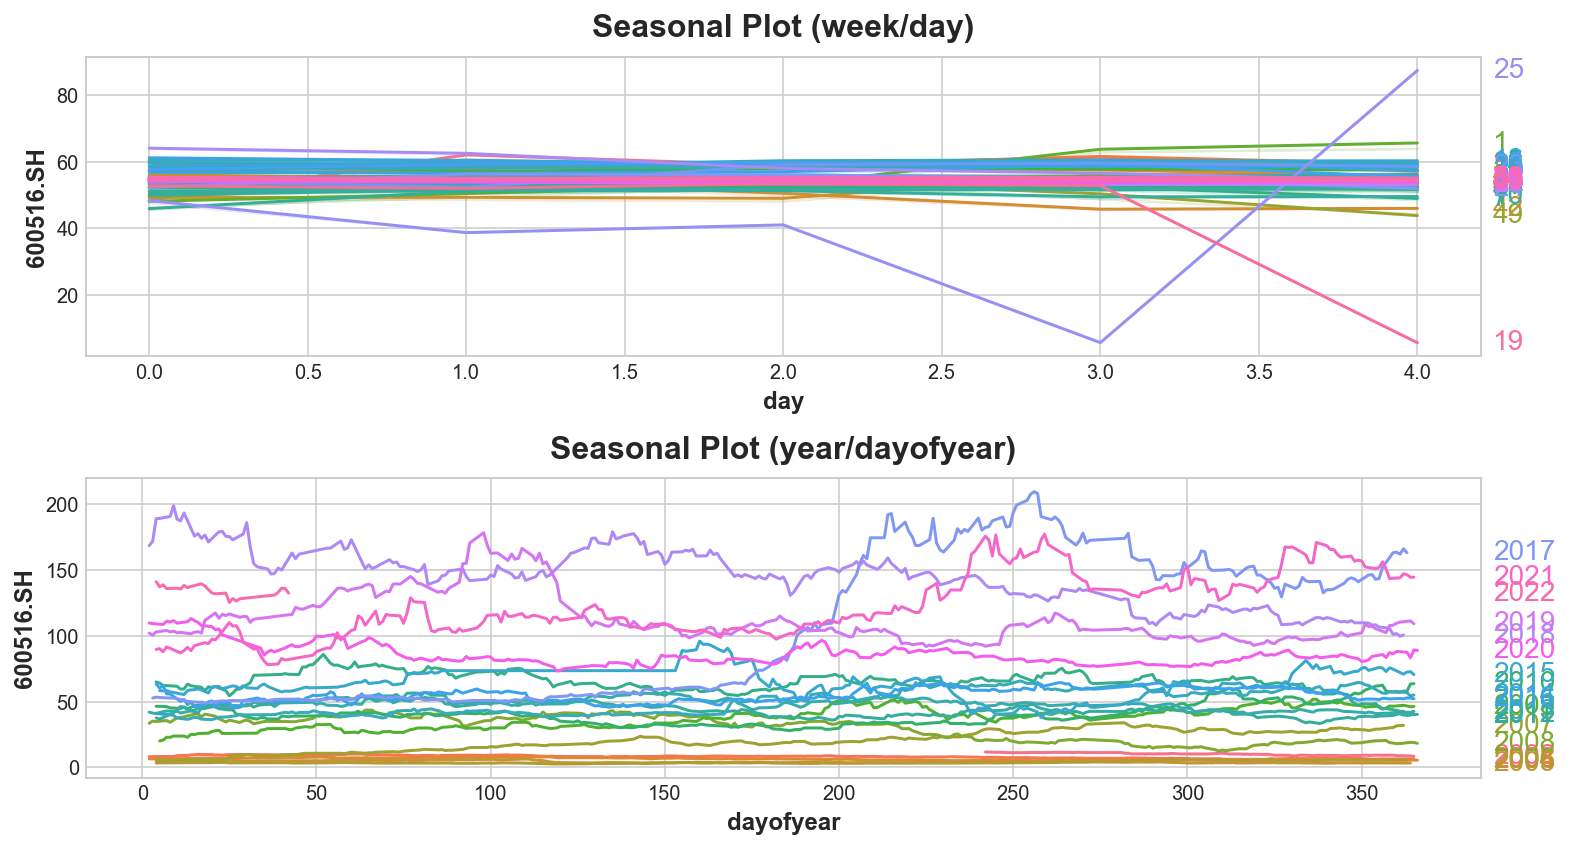

In [12]:
ticker = '600516.SH'
df0 = table[ticker]
df0.dropna(inplace=True)  # drop missing values in the feature set
df0 = df0.to_frame(name=ticker)
df0 = df0.to_period(freq ='D')
X = df0.copy()
# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)
# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y=ticker, period="week", freq="day", ax=ax0)
seasonal_plot(X, y=ticker, period="year", freq="dayofyear", ax=ax1);

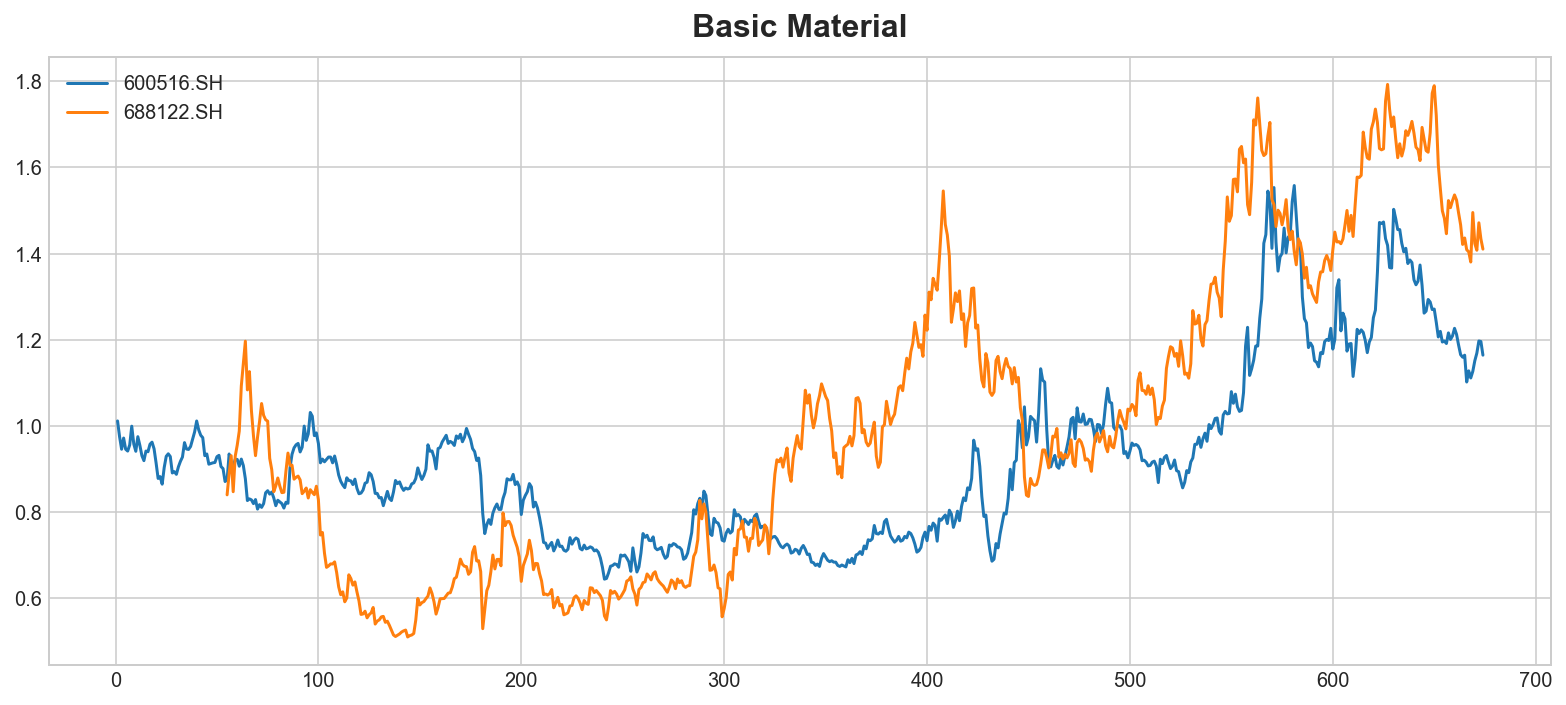

In [13]:
fig, ax = plt.subplots()
for wind_code in wind_codes:
    df0 = table[wind_code]
    # df0.dropna(inplace=True)
    df0 = df0.to_frame(name=wind_code)
    df0 = df0.to_period(freq ='D')
    df0 = df0["2019-05":]
    df0['Time'] = np.arange(len(df0.index))
    df0['pct'] = df0[wind_code].pct_change()
    df0['cumprod'] = (df0['pct'] + 1).cumprod()
    # ax = df0.plot(**plot_params)
    ax.plot('Time', 'cumprod', data=df0, label=wind_code)
    # ax = sns.regplot(x='Time', y=wind_code, data=df0, ci=None, scatter_kws=dict(color='0.25'))
    ax.set_title('Basic Material');
    _ = ax.legend()

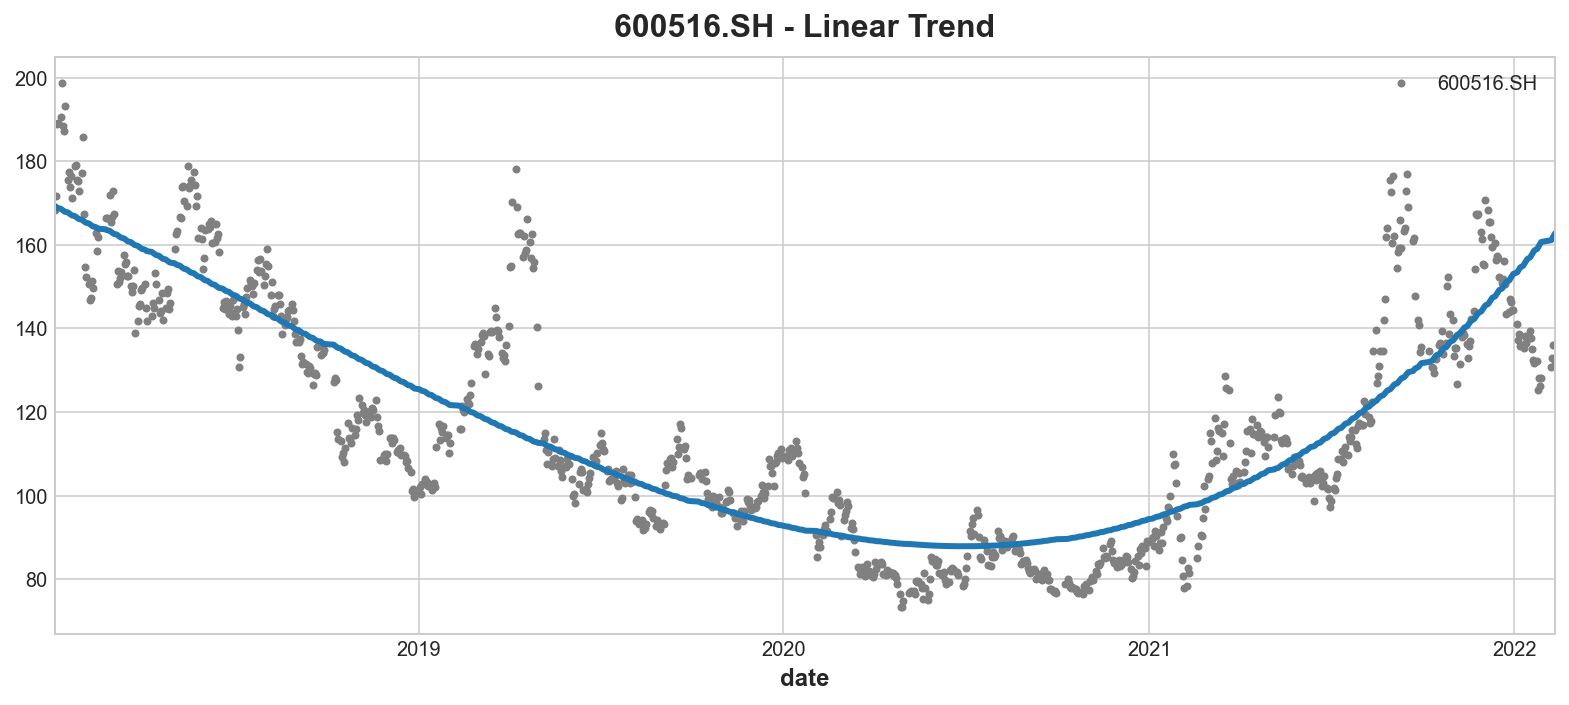

In [112]:
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression

df0 = table[wind_codes[0]]
df0.dropna(inplace=True)  # drop missing values in the feature set
df0 = df0.to_frame(name=wind_codes[0])
df0 = df0.to_period(freq ='D')
df0 = df0["2018-01":]
dp = DeterministicProcess(
    index=df0.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=3,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

y = df0[wind_codes[0]]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
ax = df0.plot(style=".", color="0.5", title=f"{wind_codes[0]} - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

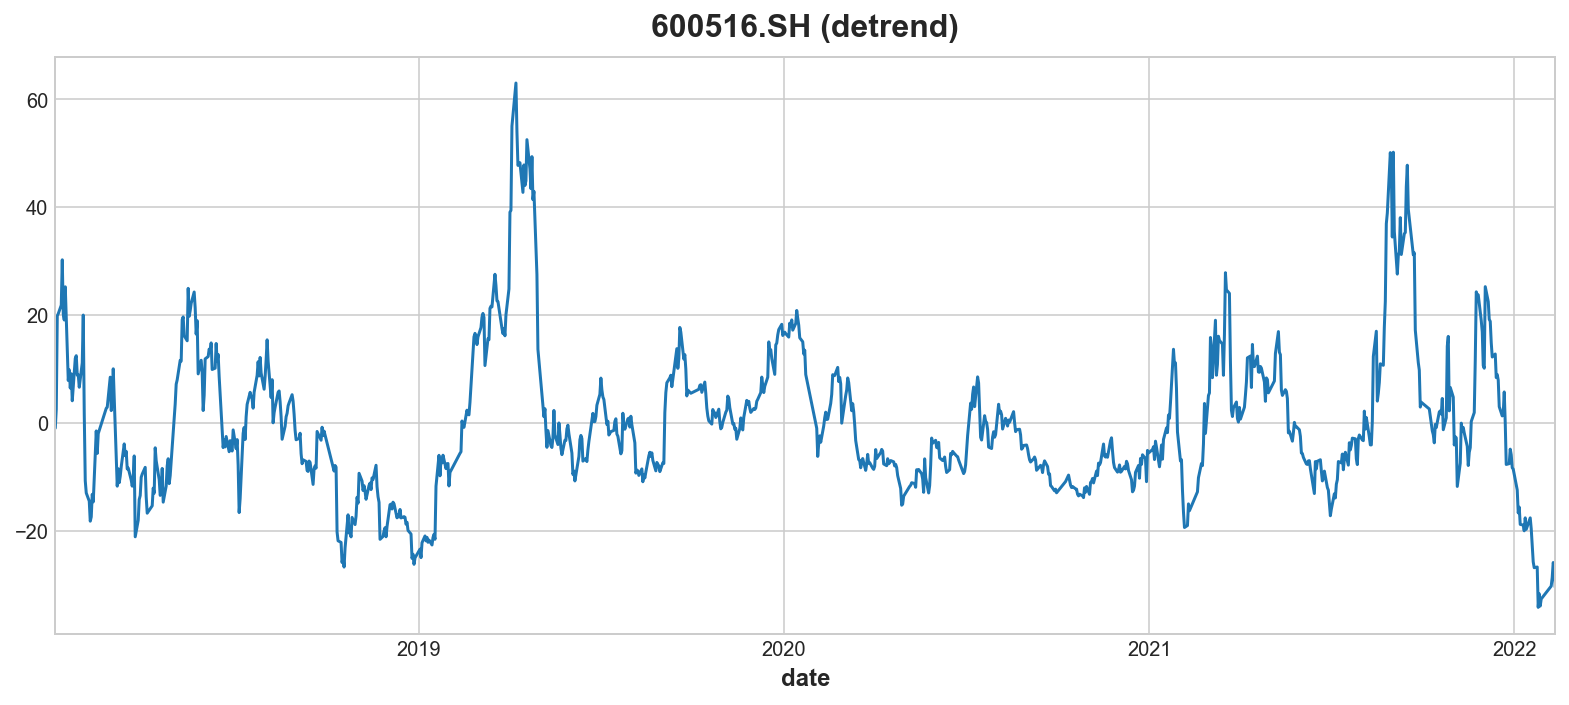

In [113]:
y_detrend = y - y_pred
y_detrend.name = 'detrend'
ax = y_detrend.plot()
ax.set_title(f"{wind_codes[0]} (detrend)");

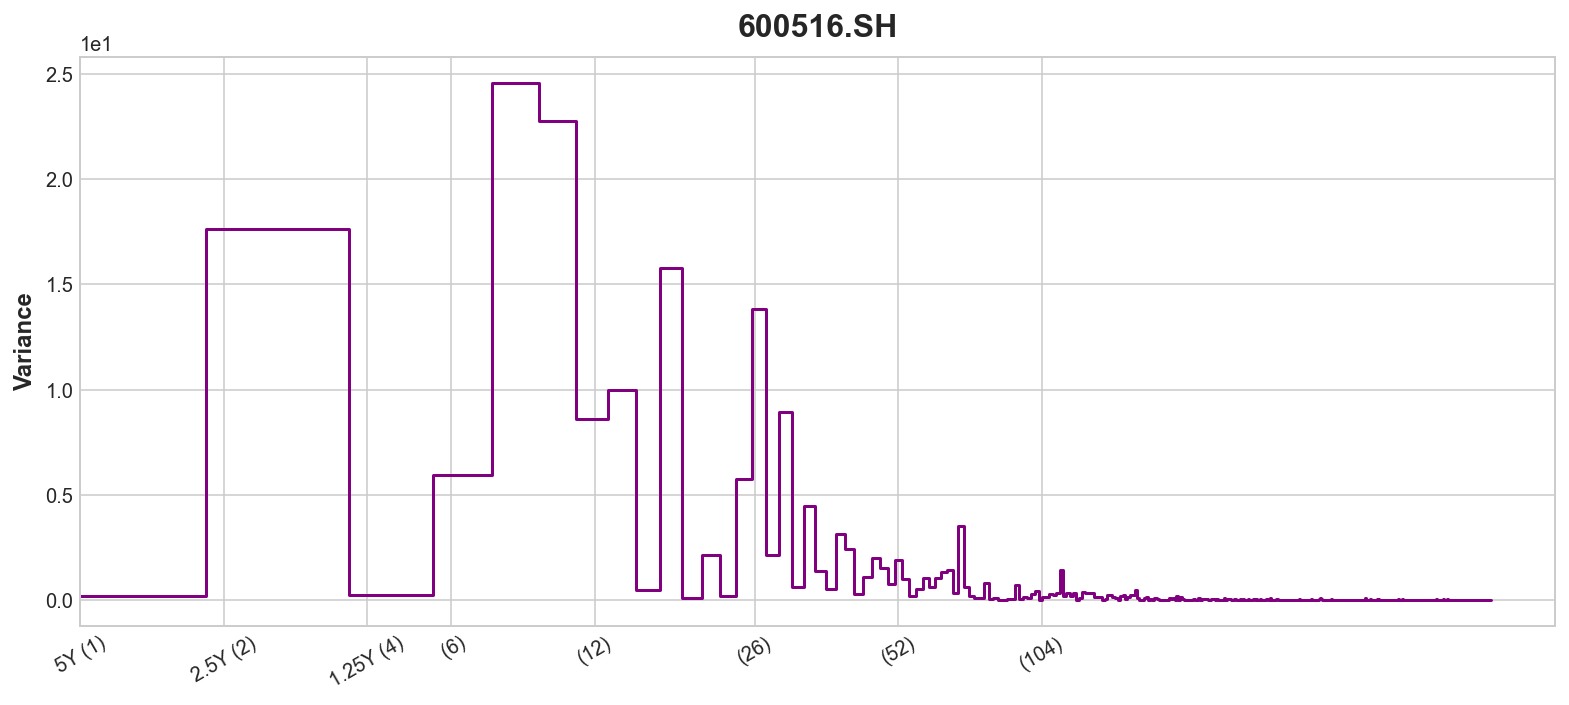

In [114]:
plot_periodogram(y_detrend,title=wind_codes[0]);

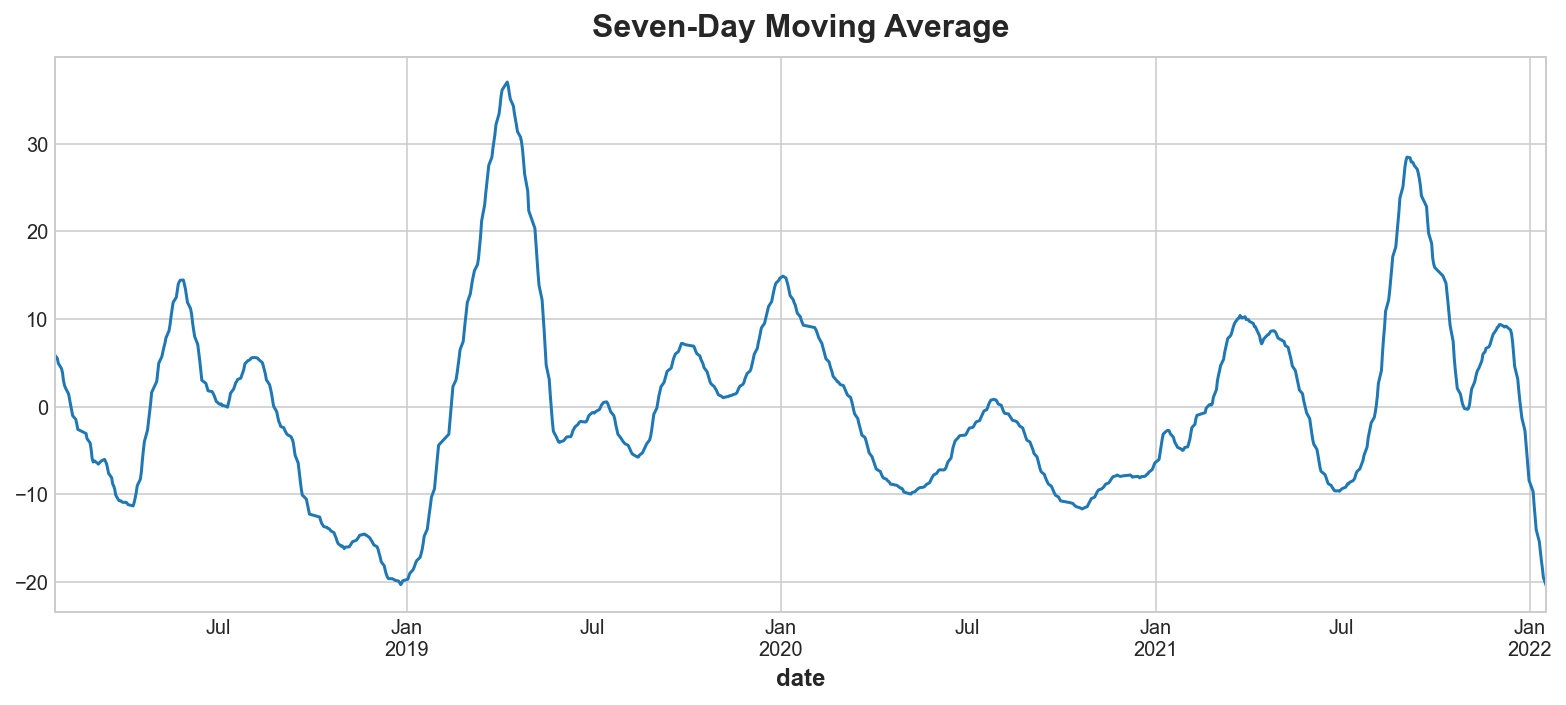

In [115]:
y_ma = y_detrend.rolling(30, center=True).mean()
y_ma.dropna(inplace=True)
ax = y_ma.plot()
ax.set_title("Seven-Day Moving Average");

In [116]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess,Fourier

fourier = CalendarFourier(freq='Y', order=4)
# fourier = Fourier(2*365, order=2)
dp = DeterministicProcess(
    constant=True,
    index=y_ma.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X = dp.in_sample()
# X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)
# y_ma.dropna(inplace=True)
model = LinearRegression(fit_intercept=False)
model.fit(X, y_ma)

LinearRegression(fit_intercept=False)

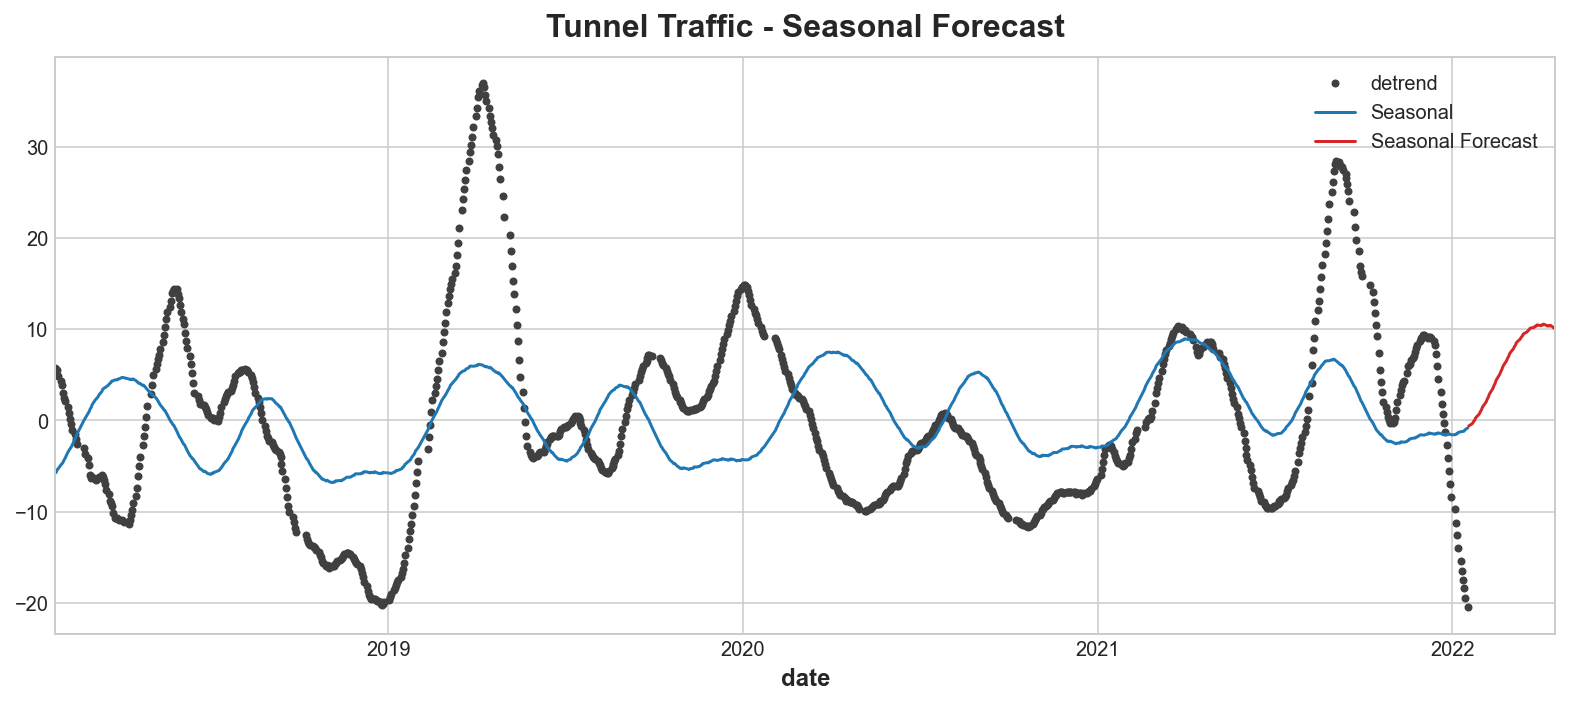

In [117]:
y_pred = pd.Series(model.predict(X), index=y_ma.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y_ma.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

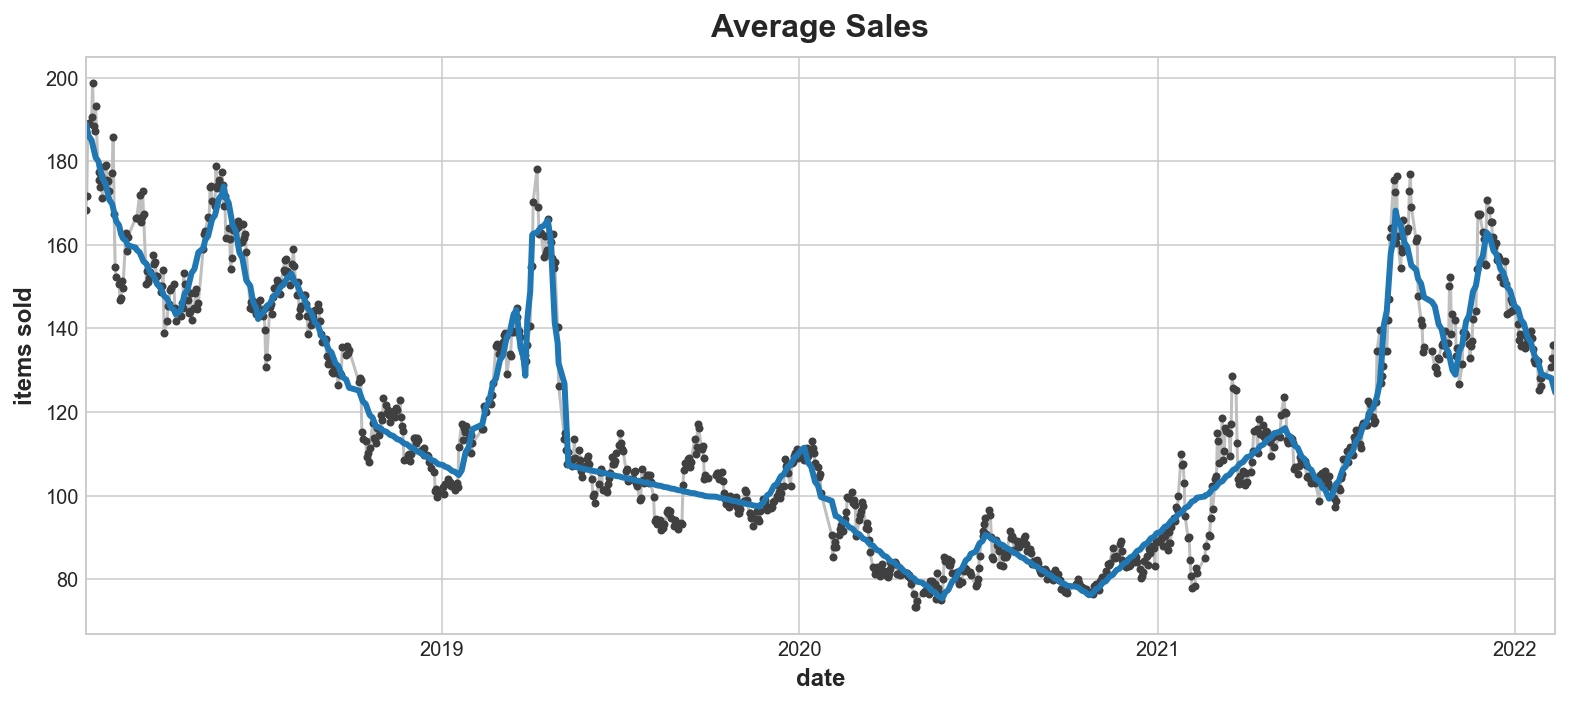

In [107]:
from pyearth import Earth

# Target and features are the same as before
y = y.copy()
dp = DeterministicProcess(index=y.index, order=1)
X = dp.in_sample()

# Fit a MARS model with `Earth`
model = Earth()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")

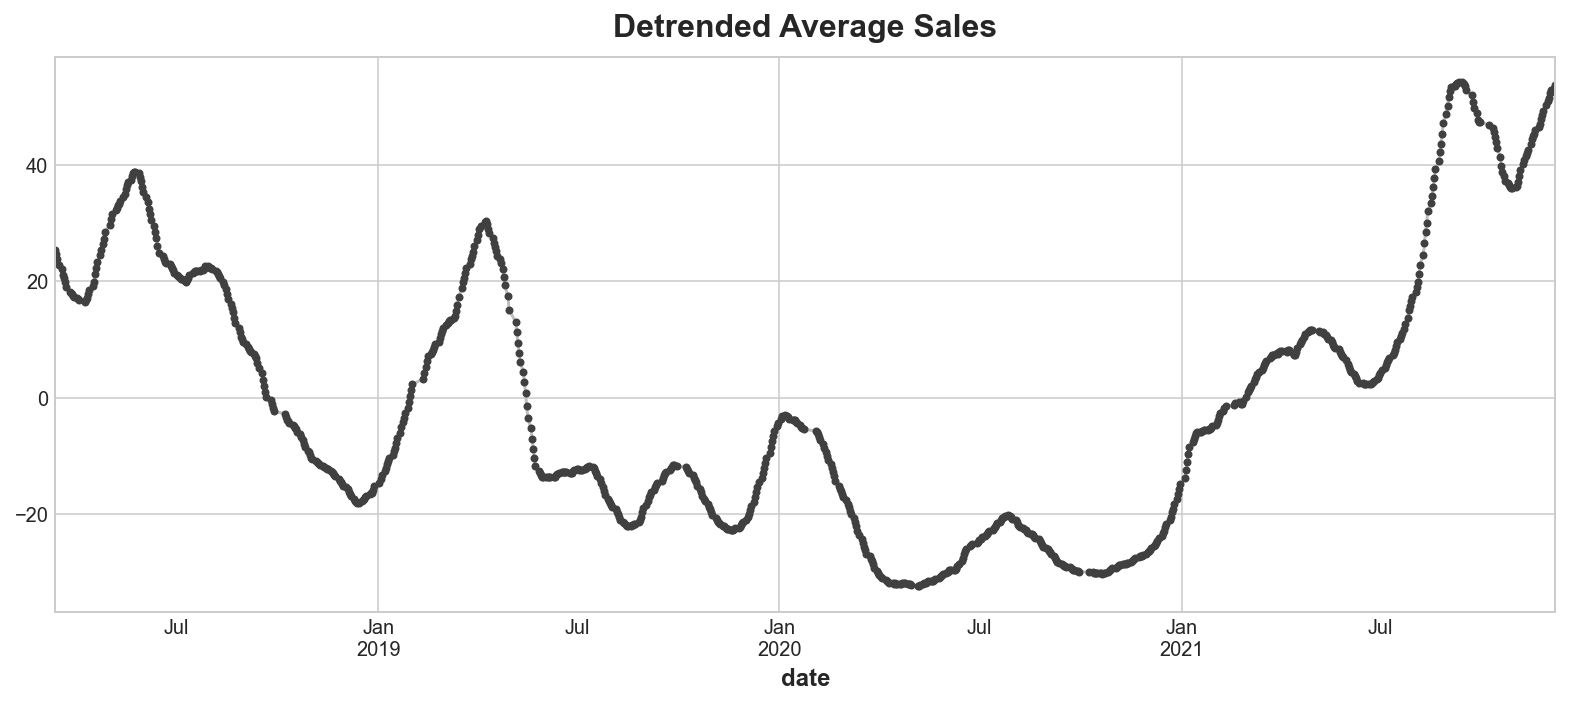

In [127]:
y_detrend = y - y_pred   # remove the trend from store_sales
y_ma = y_detrend.rolling(30, center=True).mean()
y_ma.dropna(inplace=True)
y_ma.plot(**plot_params, title="Detrended Average Sales");

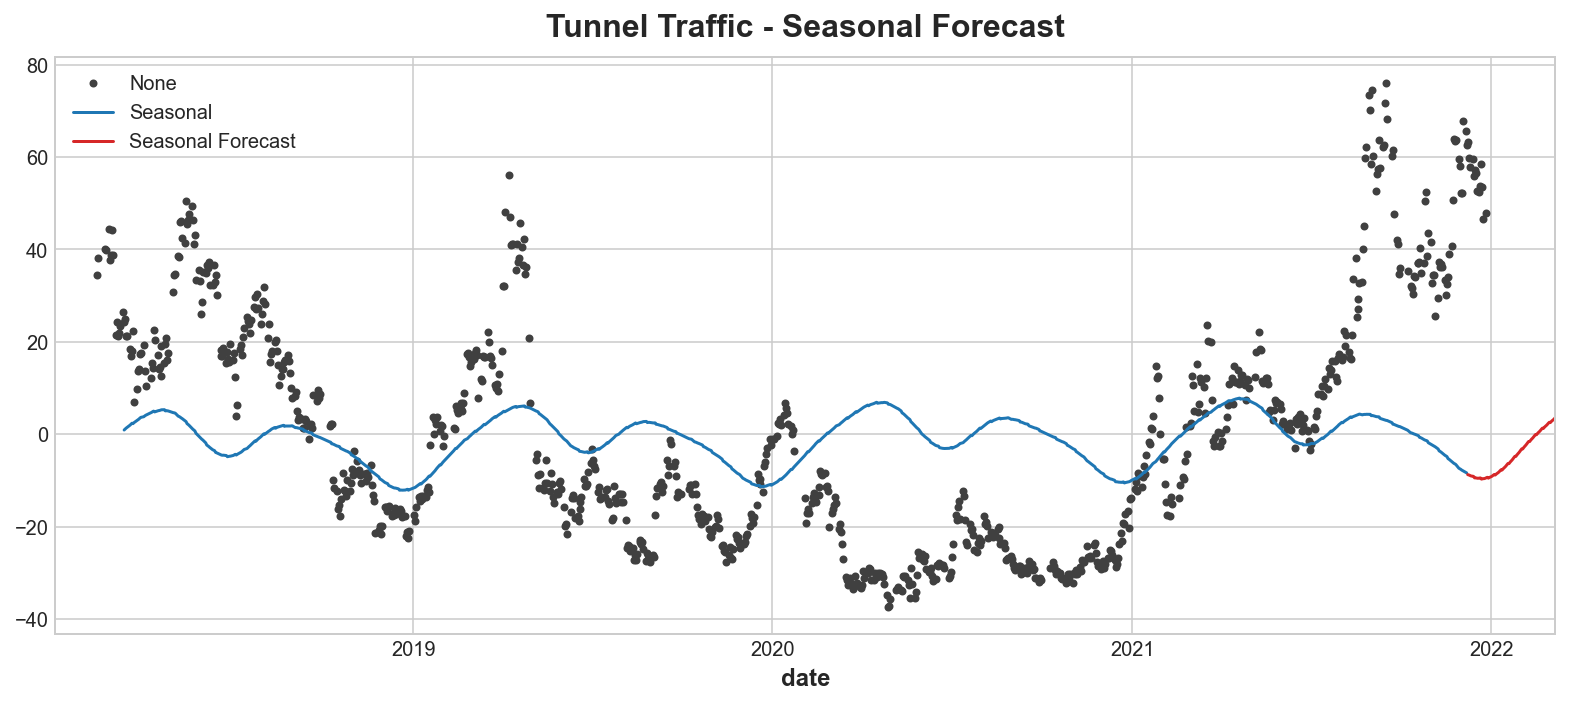

In [131]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess,Fourier

fourier = CalendarFourier(freq='Y', order=4)
# fourier = Fourier(2*365, order=2)
dp = DeterministicProcess(
    constant=True,
    index=y_ma.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X = dp.in_sample()
# X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)
# y_ma.dropna(inplace=True)
model = LinearRegression(fit_intercept=False)
model.fit(X, y_ma)
y_pred = pd.Series(model.predict(X), index=y_ma.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y_detrend.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()